# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [4]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

In [17]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init, t0, t_end = system.init, system.t0, system.t_end
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for t in linrange(t0, t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [6]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    beta, gamma = system.beta, system.gamma
    s, i, r = state

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [23]:
def get_first_value(series):
    return series.values[0]

In [24]:
def get_last_value(series):
    return series.values[-1]

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [7]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma = 0.2

0.2

Run the simulation once for each value of `beta` and print total infections.

In [14]:
pd.DataFrame({"A": [1,2,3], "B":[4,5,6]}).iloc[0]

A    1
B    4
Name: 0, dtype: int64

In [25]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

0.1 0.010756369178263281
0.2 0.11933183743303755
0.3 0.5892148636527983
0.4 0.8013400756125353
0.5 0.896577006076133
0.6 0.9429292940628492
0.7 0.966299311616815
0.8 0.9781518960589847
0.9 0.9840568958099003
1.0 0.986882350724672
1.1 0.9881481770950763


Wrap that loop in a function and return a `SweepSeries` object.

In [26]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [27]:
infected_sweep = sweep_beta(beta_array, gamma)

Parameter
0.1    0.010756
0.2    0.119332
0.3    0.589215
0.4    0.801340
0.5    0.896577
0.6    0.942929
0.7    0.966299
0.8    0.978152
0.9    0.984057
1.0    0.986882
1.1    0.988148
Name: Metric, dtype: float64

Saving figure to file figs/chap13-fig01.pdf


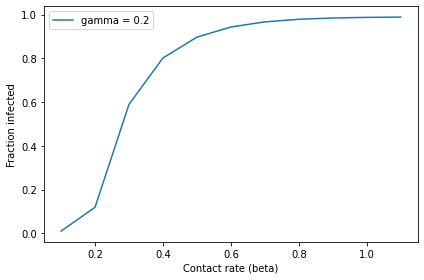

In [28]:
label = 'gamma = ' + str(gamma)
plt.plot(infected_sweep, label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

savefig('figs/chap13-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [29]:
beta_array

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

And now an array of values for `gamma`

In [30]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

[0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

Saving figure to file figs/chap13-fig02.pdf


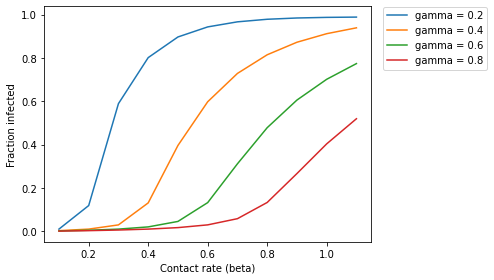

In [34]:
plt.figure(figsize=(7, 4))

for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plt.plot(infected_sweep, label=label)  

    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()
savefig('figs/chap13-fig02.pdf')

**Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [45]:
# We can estimate the time between contacts by creating a new system with a specified recovery rate

tr = 2             # recovery time in days

gamma = 1 / tr     # set the appropriate gamma

beta_array = np.linspace(.5,2,30)  # create sweep array for beta values

gamma_array = [gamma -.01, gamma, gamma+.01]  # create localized sweep for gamma values

frame = sweep_parameters(beta_array, gamma_array)  # sweep the parameters for the two arrays

,0.49,0.50,0.51
Parameter,,,
0.500000,0.151062,0.132449,0.116279
0.551724,0.265032,0.239709,0.215553
0.603448,0.379470,0.354072,0.328885
0.655172,0.478828,0.455461,0.431974
0.706897,0.562106,0.541149,0.519949
0.758621,0.631431,0.612799,0.593876
0.810345,0.689205,0.672697,0.655879
0.862069,0.737518,0.722915,0.707997
0.913793,0.778072,0.765168,0.751951


From the above SweepFrame, we can see that when we lock gamma to 0.5, the beta value needs to be between .6 and .65 in order for the total population infection rate to be 40%

In [47]:
# Solution goes here
print("Therefore, we know that the time between contacts must be between {} and {} days".format(1/.65, 1/.60))

Therefore, we know that the time between contacts must be between 1.5384615384615383 and 1.6666666666666667 days


## SweepFrame

The following sweeps two parameters and stores the results in a `SweepFrame`

In [35]:
def sweep_parameters(beta_array, gamma_array):
    """Sweep a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepFrame with one row for each beta
             and one column for each gamma
    """
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

Here's what the `SweepFrame` look like.

In [36]:
frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.119332,0.010763,0.005447,0.003644
0.3,0.589215,0.030185,0.010771,0.006526
0.4,0.801340,0.131604,0.020917,0.010780
0.5,0.896577,0.396416,0.046140,0.017640


And here's how we can plot the results.

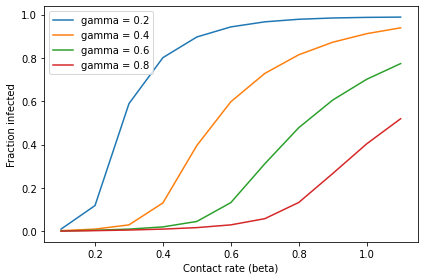

In [39]:
for gamma in gamma_array:
    label = 'gamma = ' + str(gamma)
    plt.plot(frame[gamma], label=label)
    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         title='')

We can also plot one line for each value of `beta`, although there are a lot of them.

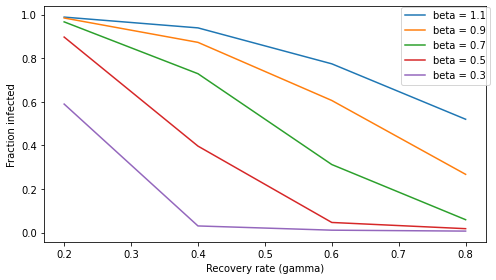

In [42]:
plt.figure(figsize=(7, 4))


for beta in [1.1, 0.9, 0.7, 0.5, 0.3]:
    label = 'beta = ' + str(beta)
    plt.plot(frame.loc[beta], label=label)
    
decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()
#savefig('figs/chap13-fig03.pdf')

It's often useful to separate the code that generates results from the code that plots the results, so we can run the simulations once, save the results, and then use them for different analysis, visualization, etc.

After running `sweep_parameters`, we have a `SweepFrame` with one row for each value of `beta` and one column for each value of `gamma`.

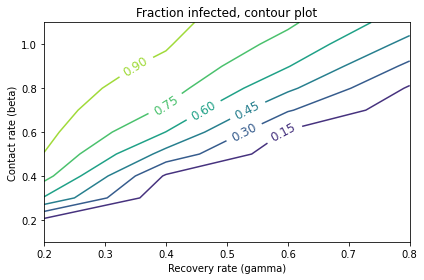

In [43]:
contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Fraction infected, contour plot')

#savefig('figs/chap13-fig04.pdf')